<a href="https://colab.research.google.com/github/ashinshanly/Multi-Sense-BiLSTM-with-POS-Tagger-Channel/blob/main/Reverse_dict_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from collections import Counter, OrderedDict
import numpy as np
import string
import re
import tensorflow
from keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, Embedding
from tensorflow.keras.layers import LSTM, Bidirectional
from keras.layers import GRU,Input
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from ms_embedding import MSEmbedding

In [ ]:
def data():    
    punc_table = str.maketrans({key: None for key in string.punctuation})
    sentences = []
    targets = []
    with open('/content/drive/MyDrive/ReverseDictionary/data/dataset_final.txt', 'r') as filee:
        for i, line in enumerate(filee):
            words = line.strip('\n').split('\t')
            word = words[0]
            definitions = words[1].split('; ')
            for definition in definitions:
                definition = re.sub("[\(\[].*?[\)\]]", "", definition).replace('  ', ' ')
                # if definition[-1] == ' ':
                #     definition = definition[:-1]

                temp_word_list = definition.translate(punc_table).lower().split(' ')
                temp_word_list = list(filter(None, temp_word_list))
                sentences.append(['<start>'] + temp_word_list + ['<end>'])
                targets.append(word)
                
    words = [word for word_sublist in sentences for word in word_sublist] 
    inf = float('inf')
    frequency_dict = OrderedDict({'<end>': inf, '<start>': inf})
    words_frequency_dict = sorted(Counter(words).most_common(None), key=lambda x:x[1], reverse=True)
    defs_frequency_dict = sorted(Counter(targets).most_common(None), key=lambda x:x[1], reverse=True)

    frequency_dict.update(words_frequency_dict)
    frequency_dict.update(defs_frequency_dict)
    frequency_dict.move_to_end('<start>', last=False)

    word2idx = OrderedDict([(item[0], i) for i,item in enumerate(frequency_dict.items())])
    idx2word = dict(zip(word2idx.values(), word2idx.keys()))
    
    return sentences, targets, word2idx, idx2word

def sent2idx(sentences, targets, word2idx):
    s = []
    for sentence in sentences:
        s.append([word2idx[word] for word in sentence])
    t = []
    for word in targets:
        t.append(word2idx[word])
    return s, t

SEQUENCE_LENGTH = 55
BATCH_SIZE = 100
EPOCHS = 10

sentences, targets, word2idx, idx2word = data()
sentences, targets = sent2idx(sentences, targets, word2idx)
targets = np_utils.to_categorical(targets)
batches = len(sentences) // BATCH_SIZE
print('Sentences:',len(sentences))
print('Vocab Size:',len(word2idx))
print('Batches:',batches)

# model = Sequential()
# model.add(Embedding(input_dim = len(word2idx), output_dim = 512))
# model.add(MSEmbedding(input_dim = len(word2idx)+1))
# model.add(Bidirectional(LSTM(512, return_sequences = True)))
# model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(512)))
# model.add(Dropout(0.2))
# model.add(Dense(len(word2idx), activation='softmax'))


inp=Input(shape=(20,))

e1 = Embedding(input_dim = len(word2idx)+1, output_dim = 512, input_length = 20,mask_zero=True)(inp)

m1 = MSEmbedding(input_dim = len(word2idx)+1,mask_zero=True,att_dims = 50)([e1,inp])
d1 = Dropout(0.2)(m1)

l1 = Bidirectional(LSTM(512, return_sequences = True))(d1)
d2 = Dropout(0.2)(l1)

l2 = Bidirectional(LSTM(512, return_sequences = False))(d2)

d3 = Dense(len(word2idx), activation='softmax')(l2)

model = Model(inputs=inp,outputs=d3)
model.compile(loss='categorical_crossentropy', optimizer='adam')

model.summary()

# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

filepath="/content/drive/MyDrive/ReverseDictionary/models/weights-improvement-Ms.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Use the other generator
'''
def generator2(inputs, targets, batch_size):
    
    batches = len(inputs) // batch_size
    for i in range(batches):
        if i == batches-1:
            batch_inputs = pad_sequences(inputs[i*batch_size:])
            batch_targets = targets[i*batch_size:]
        else:
            batch_inputs = pad_sequences(inputs[i*batch_size: (i+1)*batch_size])
            batch_targets = targets[i*batch_size: (i+1)*batch_size]
        yield batch_inputs, batch_targets
'''

def generator(inputs, targets, batch_size):
    inputs = np.array(inputs)
    perm = np.random.permutation(len(inputs))[:batch_size]
    while True:
        perm = np.random.permutation(len(inputs))[:batch_size]
        batch_inputs = pad_sequences(inputs[perm])
        batch_targets = targets[perm]
        yield batch_inputs, batch_targets
input_ = np.array(targets)
# history = model.fit_generator(generator = generator(sentences, targets, BATCH_SIZE), epochs = EPOCHS, steps_per_epoch = batches, callbacks=callbacks_list)
# ........history = model.fit(tensorflow.convert_to_tensor(pad_sequences(sentences, 20, padding='post', truncating='post')), targets,batch_size=100, epochs = EPOCHS, callbacks=callbacks_list, verbose=1, shuffle=1)
model.save('weights.h5')

Sentences: 9065
Vocab Size: 13434
Batches: 90
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 512)      6878720     input_1[0][0]                    
__________________________________________________________________________________________________
ms_embedding (MSEmbedding)      (None, 20, 512)      20687863    embedding[0][0]                  
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 20

In [ ]:
# from keras.models import model_from_json
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# print(loaded_model)
# history = modelPOS.fit_generator(generator = generator(sentences, targets, BATCH_SIZE), epochs = EPOCHS, steps_per_epoch = batches, callbacks=callbacks_list)

In [ ]:
def data():    
    punc_table = str.maketrans({key: None for key in string.punctuation})
    sentences = []
    targets = []
    with open('/content/drive/MyDrive/ReverseDictionary/data/dataset_final1.txt', 'r') as filee:
        for i, line in enumerate(filee):
            words = line.strip('\n').split('\t')
            word = words[0]
            definitions = words[1].split('; ')
            for definition in definitions:
                definition = re.sub("[\(\[].*?[\)\]]", "", definition).replace('  ', ' ')
                # if definition[-1] == ' ':
                #     definition = definition[:-1]

                temp_word_list = definition.translate(punc_table).lower().split(' ')
                temp_word_list = list(filter(None, temp_word_list))
                sentences.append(['<start>'] + temp_word_list + ['<end>'])
                targets.append(word)
                
    words = [word for word_sublist in sentences for word in word_sublist] 
    inf = float('inf')
    frequency_dict = OrderedDict({'<end>': inf, '<start>': inf})
    words_frequency_dict = sorted(Counter(words).most_common(None), key=lambda x:x[1], reverse=True)
    defs_frequency_dict = sorted(Counter(targets).most_common(None), key=lambda x:x[1], reverse=True)

    frequency_dict.update(words_frequency_dict)
    frequency_dict.update(defs_frequency_dict)
    frequency_dict.move_to_end('<start>', last=False)

    word2idx = OrderedDict([(item[0], i) for i,item in enumerate(frequency_dict.items())])
    idx2word = dict(zip(word2idx.values(), word2idx.keys()))
    
    return sentences, targets, word2idx, idx2word

def sent2idx(sentences, targets, word2idx):
    s = []
    for sentence in sentences:
        s.append([word2idx[word] for word in sentence])
    t = []
    for word in targets:
        t.append(word2idx[word])
    return s, t

SEQUENCE_LENGTH = 55
BATCH_SIZE = 100
EPOCHS = 10

sentences, targets, word2idx, idx2word = data()
sentences, targets = sent2idx(sentences, targets, word2idx)
targets = np_utils.to_categorical(targets)
batches = len(sentences) // BATCH_SIZE
print('Sentences:',len(sentences))
print('Vocab Size:',len(word2idx))
print('Batches:',batches)



# Use the other generator
'''
def generator2(inputs, targets, batch_size):
    
    batches = len(inputs) // batch_size
    for i in range(batches):
        if i == batches-1:
            batch_inputs = pad_sequences(inputs[i*batch_size:])
            batch_targets = targets[i*batch_size:]
        else:
            batch_inputs = pad_sequences(inputs[i*batch_size: (i+1)*batch_size])
            batch_targets = targets[i*batch_size: (i+1)*batch_size]
        yield batch_inputs, batch_targets
'''

def generator(inputs, targets, batch_size):
    inputs = np.array(inputs)
    perm = np.random.permutation(len(inputs))[:batch_size]
    while True:
        perm = np.random.permutation(len(inputs))[:batch_size]
        batch_inputs = pad_sequences(inputs[perm])
        batch_targets = targets[perm]
        yield batch_inputs, batch_targets

Sentences: 8920
Vocab Size: 13298
Batches: 89


In [ ]:
inp=Input(shape=(20,))

e1 = Embedding(input_dim = len(word2idx)+1, output_dim = 512, input_length = 20,mask_zero=True)(inp)
m1 = MSEmbedding(input_dim = len(word2idx)+1,mask_zero=True,att_dims = 50)([e1,inp])
d1 = Dropout(0.2)(m1)
l1 = Bidirectional(LSTM(512, return_sequences = True))(d1)
d2 = Dropout(0.2)(l1)
l2 = Bidirectional(LSTM(512, return_sequences = False))(d2)
d3 = Dense(len(word2idx), activation='softmax')(l2)
model = Model(inputs=inp,outputs=d3)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

filepath="/content/drive/MyDrive/ReverseDictionary/models/weights-improvement-Ms.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.load_weights('/content/drive/MyDrive/ReverseDictionary/models/weights-improvement-Ms.hdf5')
# history = model.fit(tensorflow.convert_to_tensor(pad_sequences(sentences, 20, padding='post', truncating='post')), targets,batch_size=100, epochs = 1000, callbacks=callbacks_list, verbose=1, shuffle=1)
# model.save('weights.h5')

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 512)      6809088     input_2[0][0]                    
__________________________________________________________________________________________________
ms_embedding_1 (MSEmbedding)    (None, 20, 512)      20478967    embedding_1[0][0]                
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 20, 512)      0           ms_embedding_1[0][0]  

In [ ]:
history = model.fit(tensorflow.convert_to_tensor(pad_sequences(sentences, 20, padding='post', truncating='post')), targets,batch_size=100, epochs = 100, callbacks=callbacks_list, verbose=1, shuffle=1) 

Epoch 1/100
90/90 [==============================] - ETA: 0s - loss: 0.0870
Epoch 00001: loss improved from inf to 0.08703, saving model to /content/drive/MyDrive/ReverseDictionary/models/weights-improvement-Ms.hdf5
90/90 [==============================] - 32s 361ms/step - loss: 0.0870
Epoch 2/100
90/90 [==============================] - ETA: 0s - loss: 0.0626
Epoch 00002: loss improved from 0.08703 to 0.06261, saving model to /content/drive/MyDrive/ReverseDictionary/models/weights-improvement-Ms.hdf5
90/90 [==============================] - 28s 314ms/step - loss: 0.0626
Epoch 3/100
90/90 [==============================] - ETA: 0s - loss: 0.0638
Epoch 00003: loss did not improve from 0.06261
90/90 [==============================] - 25s 276ms/step - loss: 0.0638
Epoch 4/100
90/90 [==============================] - ETA: 0s - loss: 0.0714
Epoch 00004: loss did not improve from 0.06261
90/90 [==============================] - 24s 262ms/step - loss: 0.0714
Epoch 5/100
90/90 [===============

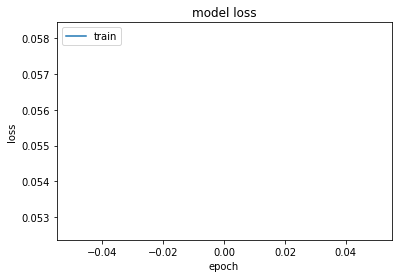

In [ ]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
antonym_data = open("/content/drive/MyDrive/ReverseDictionary/data/antonyms.txt","r")
antonyms = {}
for lines in antonym_data:
    line = lines.split("\t")
    antonyms[line[0]] = line[1].replace("\n","")
print(antonyms)

{'terminal': 'final', 'tribal': 'indigenous', 'philosophical': 'composed', 'provident': 'thrifty', 'excitable': 'wild', 'unfavorable': 'unsuited', 'unstructured': 'unorganized', 'disciplinary': 'corrective', 'deaf': 'insensate', 'unrefined': 'unskilled', 'mystical': 'divine', 'geologic': 'mineral', 'immortal': 'everlasting', 'arboreal': 'treelike', 'able': 'capable', 'unlawful': 'criminal', 'indispensable': 'necessary', 'photographic': 'photo', 'pneumatic': 'mechanical', 'inconsolable': 'despondent', 'symbolic': 'metaphorical', 'historic': 'old', 'maximum': 'utmost', 'taxonomic': 'unclassified', 'endemic': 'regional', 'intentional': 'purposeful', 'funded': 'subsidized', 'uneven': 'tilted', 'invalid': 'erroneous', 'symphonic': 'harmonic', 'concise': 'exact', 'psychiatric': 'disturbed', 'digestive': 'abdominal', 'superficial': 'glib', 'representative': 'demonstrative', 'mortal': 'life-threatening', 'disadvantageous': 'harmful', 'pathological': 'minded', 'pulmonary': 'systemic', 'sensory'

In [ ]:
definition = input().lower()
#print(definition)
words = definition.split(' ')
stopwords = ['a','an','the','is','are']
if(len(words)>18):
  for x in stopwords:
    if x in words:
      words.remove(x)
n = 0
if 'antonym' in words:
    keyword = words[len(words)-1]
    antonym_data = open("/content/drive/MyDrive/ReverseDictionary/data/antonyms.txt","r")
    antonyms = []    
    for lines in antonym_data:
        line = lines.split("\t")
        if(line[0]==keyword):
            antonyms.append(line[1].replace("\n",""))
    print(antonyms)
    n = len(antonyms)
idxs = []
for word in words:
  if word in idx2word:
    idxs.append(word2idx[word])
l = 18 - len(idxs)
# print(l)
# idxs = np.array([0] + idxs + [1]).reshape((1,len(idxs) + 2))
idxs = np.pad(np.array([0] + idxs + [1]), (0,l), 'constant', constant_values=(0))
# print(idxs)
idxs = idxs.reshape((1,20)) 
prediction = model.predict(idxs, verbose=0)
print(prediction)
# index = np.argmax(prediction)
ind=np.argpartition(prediction[0],-10)[-10:]
print(ind)
for i in ind[::-1]:
  # meaning = idx2word[index]
  meaning = idx2word[i]
  print(meaning)


when you knew a fact or to do something in the past but then without trying you lost this knowledge
[[1.7899694e-05 1.6158327e-05 1.8346471e-05 ... 3.8358507e-05
  9.7346247e-06 1.6236262e-06]]
[12188 11954   661 13254 12823   335 12458 12952 10937  1230]
press
encroaching
sputter
disjoint
party
seriocomic
mostra
possession
furred
asterisked


In [ ]:
predictions = []
ground_truth = []
test = open('/content/drive/MyDrive/ReverseDictionary/data/dataset_final1.txt', 'r')
for i, line in enumerate(test):
    if(i==100):
      break
    else:
      print("Testing " + str(i) + "/200")
      print(line)
    line = line.strip('\n').split('\t')
    # if(line[0] not in idx2word):
    #   continue
    ground_truth.append(word2idx[line[0]])
    # print(ground_truth)
    definition = list(set(line[1].split(' ')))

    stopwords = ['a','an','the','is','are','in','of','by','at']
    if(len(definition)>18):
      for x in stopwords:
        if x in definition:
          definition.remove(x)
    idxs = []
    for word in definition:
        if(word==""):
          continue
        idxs.append(word2idx[word])
    l = 18 - len(idxs)
    # print(l)
    #idxs = np.array([0] + idxs + [1]).reshape((1,len(idxs) + 2))
    idxs = np.pad(np.array([0] + idxs + [1]), (0,l), 'constant', constant_values=(0))
    idxs = idxs.reshape((1,20)) 
    prediction = model.predict(idxs, verbose=0)
    ind=np.argpartition(prediction[0],-100)[-100:]
    # print(ind)
    for j in ind[:10:-1]:
      print(idx2word[j],end="\t")
    predictions.append(ind)
    # print(predictions)

A_1,A_10,A_100,med,sq = evaluate_test(ground_truth,predictions)
print("Accuracy @ 1 = "+ str(A_1))
print("Accuracy @ 10 = "+ str(A_10))
print("Accuracy @ 100 = "+ str(A_100))
print("Median Prediction Rank = "+ str(med))
# print("Accuracy @ 1 = "+ A_1)

Testing 0/200
forget	when you knew a fact or to do something in the past but then without trying you lost this knowledge

sandstorm	office	river	mouth	stroke	straw	rile	limitation	supply	laugh	twofer	tracks	sprouting	roots	pride	kindergarten	rushes	greedy	marsala	orientated	remember	sympathy	church	ambition	sea	ender	homosexualism	paper	infinitesimal	sill	showstopper	clandestine	excess	transporter	five	flea	forget	hangover	panoply	emergent	ice	remain	extrude	race	sharing	kiosk	grifter	bars	patient	explain	sound	shrubland	tope	tallest	protect	bird	stepping	stainer	music	varnish	knowledge	thanks	hear	demeaning	accelerating	bb	rehabilitate	hat	superstar	island	tulsa	inanimate	gripping	unhealthiness	english	occidental	pipes	savoring	poseur	government	demean	reflection	army	moved	uh	prints	east	rockefeller	charisma	Testing 1/200
office	a room in a house or building where people study or work

slant	assort	internet	spiking	pride	audience	video	roller	star	demean	green	fight	readied	axonal	mo

NameError: ignored

In [ ]:
import numpy as np
def evaluate(ground_truth, prediction):
    accu_1 = 0.
    accu_10 = 0.
    accu_100 = 0.
    length = len(ground_truth)
    for i in range(length):
        if ground_truth[i] in prediction[i][:100]:
            accu_100 += 1
            if ground_truth[i] in prediction[i][:10]:
                accu_10 += 1
                if ground_truth[i] == prediction[i][0]:
                    accu_1 += 1
    return accu_1/length*100, accu_10/length*100, accu_100/length*100

def evaluate_test(ground_truth, prediction):
    # print(ground_truth)
    # print(prediction)
    accu_1 = 0.
    accu_10 = 0.
    accu_100 = 0.
    length = len(ground_truth)
    pred_rank = []
    for i in range(length):
        try:
            # print(i)
            # print(prediction[i].tolist().index(ground_truth[i]))
            pred_rank.append(prediction[i].tolist().index(ground_truth[i]))
        except:
            pred_rank.append(1000)
        if ground_truth[i] in prediction[i][:100]:
            accu_100 += 1
            if ground_truth[i] in prediction[i][:10]:
                accu_10 += 1
                if ground_truth[i] == prediction[i][0]:
                    accu_1 += 1
    print(pred_rank)
    return accu_1/length*100, accu_10/length*100, accu_100/length*100, np.median(pred_rank), np.sqrt(np.var(pred_rank))

In [ ]:
from keras.models import model_from_json
json_file = open('modelPOS.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
modelPOS = model_from_json(loaded_model_json)

definition = input().lower()
#print(definition)
words = definition.split(' ')
idxs = []
POS2idx = OrderedDict([('<start>', 0), ('<end>', 1), ('noun', 2), ('verb', 3), ('adp', 4), ('det', 5), ('conj', 6), ('adj', 7), ('adv', 8), ('prt', 9), ('pron', 10), ('num', 11), ('x', 12), ('ADV', 13), ('NOUN', 14), ('VERB', 15), ('ADJ', 16), ('ADP', 17), ('DET', 18), ('PRON', 19), ('NUM', 20), ('CONJ', 21), ('PRT', 22)])
idx2POS = OrderedDict([(0,'<start>'), (1, '<end>'), (2, 'noun'), (3, 'verb'), (4, 'adp'), (5, 'det'), (6, 'conj'), (7, 'adj'), (8, 'adv'), (9, 'prt'), (10, 'pron'), (11, 'num'), (12,'x'), (13, 'ADV'), (14, 'NOUN'), (15, 'VERB'), (16, 'ADJ'), (17, 'ADP'), (18, 'DET'), (19, 'PRON'), (20, 'NUM'), (21, 'CONJ'), (22, 'PRT')])
for word in words:
    idxs.append(POS2idx[word])

idxs = np.array([0] + idxs + [1]).reshape((1,len(idxs) + 2))

POSprediction = modelPOS.predict(idxs, verbose=0)
# index = np.argmax(prediction)
ind=np.argpartition(POSprediction[0],-3)[-3:]
for i in ind:
  # meaning = idx2word[index]
  tags = idx2POS[i]
  print(tags)

In [ ]:
!pip install flask-ngrok
from flask_ngrok import run_with_ngrok
from flask import Flask, request, jsonify, render_template, logging 
import webbrowser 

In [ ]:
def create_app():
    app = Flask(__name__, template_folder='drive/My Drive/Colab Notebooks/templates', static_folder='drive/My Drive/Colab Notebooks/static')  
    return app
    
app = create_app()

#WEB-APP
@app.route('/', methods=['GET', 'POST'])
def index():
    meanings=[]
    if request.method == 'POST':
        words = request.form['definition'].split()        
        idxs = [] 
        for word in words:
          idxs.append(word2idx[word])  
        idxs = np.array([0] + idxs + [1]).reshape((1,len(idxs) + 2))
        prediction = model.predict(idxs, verbose=0)
        ind=np.argpartition(prediction[0],-10)[-10:]
        for i in ind[::-1]:
          meanings.append(idx2word[i])

        return jsonify(meanings)        
    else:
        #return "<h1>Running Flask on Google Colab!</h1>"
        return render_template('indexMS.html')


run_with_ngrok(app) 
app.run()

        

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://c5acacd69b3a.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [07/Dec/2020 06:02:32] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 06:02:32] "GET /static/css/bulma/bulma.min.css HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 06:02:32] "GET /static/js/jquery-3.3.1.min.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 06:02:33] "GET /static/js/main.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Dec/2020 06:02:50] "GET /favicon.ico HTTP/1.1" 404 -
[2020-12-07 06:02:53,417] ERROR in app: Exception on / [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.6/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/